<a href="https://colab.research.google.com/github/north-sound-peng/Football-Player-Valuation/blob/main/FINAL_DSBProjectData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import requests

Mounted at /content/drive


In [ ]:
# Load each dataset
players = pd.read_csv('/content/drive/MyDrive/Football Stats/players.csv')
playervaluations = pd.read_csv('/content/drive/MyDrive/Football Stats/player_valuations.csv')
games = pd.read_csv('/content/drive/MyDrive/Football Stats/games.csv')
gamelineups = pd.read_csv('/content/drive/MyDrive/Football Stats/game_lineups.csv')
competitions = pd.read_csv('/content/drive/MyDrive/Football Stats/competitions.csv')
clubs = pd.read_csv('/content/drive/MyDrive/Football Stats/clubs.csv')
appearances = pd.read_csv('/content/drive/MyDrive/Football Stats/appearances.csv')
sportsref_stats = pd.read_csv('/content/drive/MyDrive/Football Stats/sportsref.csv', header=1)

In [ ]:
sportsref_stats=sportsref_stats.drop(['Rk','Nation'], axis=1)
sportsref_stats

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,Dist,FK,Gls,Ast,G+A,G-PK,PK,PKatt,PKm,Pos
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,"2,946",32.7,34,...,13.6,3,35,3,38,30,5,5,0,FW
1,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,"2,458",27.3,28,...,13.8,5,41,7,48,33,8,9,1,FW
2,Robert Lewandowski,30.7,2019-2020,30,Bayern Munich,de Bundesliga,31,"2,759",30.7,31,...,13.4,2,34,4,38,29,5,5,0,FW
3,Robert Lewandowski,30.7,2018-2019,29,Bayern Munich,de Bundesliga,33,"2,957",32.9,33,...,13.2,5,22,7,29,19,3,4,1,FW
4,Cristiano Ronaldo,28.6,2019-2020,34,Juventus,it Serie A,33,"2,917",32.4,33,...,19.5,19,31,5,36,19,12,13,1,FW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Callum Wilson,7.6,2017-2018,25,Bournemouth,eng Premier League,28,"1,981",22.0,23,...,13.6,0,8,2,10,8,0,0,0,FW
996,Chris Wood,7.3,2021-2022,29,2 Teams,eng Premier League,34,"2,694",29.9,32,...,12.4,0,5,0,5,4,1,1,0,FW
997,Chris Wood,7.8,2023-2024,31,Nott'ham Forest,eng Premier League,26,"1,375",15.3,15,...,10.6,0,12,1,13,12,0,0,0,FW
998,Wilfried Zaha,8.1,2020-2021,27,Crystal Palace,eng Premier League,30,"2,612",29.0,29,...,16.9,0,11,2,13,9,2,2,0,FW


In [ ]:
# making a list with the dataframes
dfs = [players, playervaluations, games, gamelineups, competitions, clubs, appearances]

In [ ]:
# looking at the datatypes
for i in dfs:
  print(i.dtypes)
  print("-------------------------------------------------------------")

player_id                                 int64
first_name                               object
last_name                                object
name                                     object
last_season                               int64
current_club_id                           int64
player_code                              object
country_of_birth                         object
city_of_birth                            object
country_of_citizenship                   object
date_of_birth                            object
sub_position                             object
position                                 object
foot                                     object
height_in_cm                            float64
contract_expiration_date                 object
agent_name                               object
image_url                                object
url                                      object
current_club_domestic_competition_id     object
current_club_name                       

In [ ]:
# seeing how many null values there are
for i in dfs:
  print(i.isnull().sum())
  print("-------------------------------------------------------------")

player_id                                   0
first_name                               1991
last_name                                   0
name                                        0
last_season                                 0
current_club_id                             0
player_code                                 0
country_of_birth                         2710
city_of_birth                            2200
country_of_citizenship                    566
date_of_birth                              46
sub_position                              174
position                                    0
foot                                     2377
height_in_cm                             2087
contract_expiration_date                11465
agent_name                              15377
image_url                                   0
url                                         0
current_club_domestic_competition_id        0
current_club_name                           0
market_value_in_eur               

In [ ]:
# making a dictionary of the dataframes
dfs_dict = {
    'players': dfs[0],
    'playervaluations': dfs[1],
    'games': dfs[2],
    'gamelineups': dfs[3],
    'competitions': dfs[4],
    'clubs': dfs[5],
    'appearances': dfs[6],
}

In [ ]:
# making a function to align the dataframes using the minimum date
def align_dataframes_by_date(dataframes, date):
    min_dates = {}

    # Step 1: Convert date columns to datetime and find the minimum date for each dataframe that has the date column
    for name, df in dataframes.items():
        if date in df.columns:
            df[date] = pd.to_datetime(df[date])
            min_dates[name] = df[date].min()

    # Step 2: Determine the latest of the minimum dates
    max_min_date = max(min_dates.values())

    # Step 3: Trim each dataframe to start from this maximum minimum date
    aligned_dataframes = {}
    for name, df in dataframes.items():
        if date in df.columns:
            aligned_dataframes[name] = df[df[date] >= max_min_date]

    return aligned_dataframes

In [ ]:
# aligning the datframes using the function
dfs_dict = align_dataframes_by_date(dfs_dict, 'date')

In [ ]:
# Reassign aligned dataframes from the dictionary back to individual dataframe variables
players = dfs_dict.get('players', players)  # Using .get() to provide a fallback to the original if not aligned
playervaluations = dfs_dict.get('playervaluations', playervaluations)
games = dfs_dict.get('games', games)
gamelineups = dfs_dict.get('gamelineups', gamelineups)
competitions = dfs_dict.get('competitions', competitions)
clubs = dfs_dict.get('clubs', clubs)
appearances = dfs_dict.get('appearances', appearances)

In [ ]:
# checking data alignment
print(playervaluations['date'].min())
print(playervaluations['date'].max())
print(appearances['date'].min())
print(appearances['date'].max())

2012-07-03 00:00:00
2024-02-02 00:00:00
2012-07-03 00:00:00
2024-02-05 00:00:00


In [ ]:
# making a new list with the aligned dataframes
dfs = [players, playervaluations, games, gamelineups, competitions, clubs, appearances]

# making a new dictionary of the dataframes
dfs_dict = {
    'players': dfs[0],
    'playervaluations': dfs[1],
    'games': dfs[2],
    'gamelineups': dfs[3],
    'competitions': dfs[4],
    'clubs': dfs[5],
    'appearances': dfs[6]
}

In [ ]:
playervaluations

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
77502,10,2012-07-03,6000000,398,IT1
77503,3515,2012-07-03,800000,383,NL1
77504,4311,2012-07-03,8000000,610,NL1
77505,4673,2012-07-03,28000000,417,FR1
77506,5023,2012-07-03,16000000,506,IT1
...,...,...,...,...,...
465155,1144851,2024-01-28,50000,3209,TR1
465156,1225269,2024-01-28,50000,3209,TR1
465157,853535,2024-01-29,700000,2293,TR1
465158,743526,2024-02-01,50000,3840,TR1


In [ ]:
names = sportsref_stats['Player'].str.split(" ", n=1, expand=True)
sportsref_stats['FirstName'] = names[0]
sportsref_stats['LastName'] = names[1]
sportsref_stats

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,Gls,Ast,G+A,G-PK,PK,PKatt,PKm,Pos,FirstName,LastName
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,"2,946",32.7,34,...,35,3,38,30,5,5,0,FW,Robert,Lewandowski
1,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,"2,458",27.3,28,...,41,7,48,33,8,9,1,FW,Robert,Lewandowski
2,Robert Lewandowski,30.7,2019-2020,30,Bayern Munich,de Bundesliga,31,"2,759",30.7,31,...,34,4,38,29,5,5,0,FW,Robert,Lewandowski
3,Robert Lewandowski,30.7,2018-2019,29,Bayern Munich,de Bundesliga,33,"2,957",32.9,33,...,22,7,29,19,3,4,1,FW,Robert,Lewandowski
4,Cristiano Ronaldo,28.6,2019-2020,34,Juventus,it Serie A,33,"2,917",32.4,33,...,31,5,36,19,12,13,1,FW,Cristiano,Ronaldo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Callum Wilson,7.6,2017-2018,25,Bournemouth,eng Premier League,28,"1,981",22.0,23,...,8,2,10,8,0,0,0,FW,Callum,Wilson
996,Chris Wood,7.3,2021-2022,29,2 Teams,eng Premier League,34,"2,694",29.9,32,...,5,0,5,4,1,1,0,FW,Chris,Wood
997,Chris Wood,7.8,2023-2024,31,Nott'ham Forest,eng Premier League,26,"1,375",15.3,15,...,12,1,13,12,0,0,0,FW,Chris,Wood
998,Wilfried Zaha,8.1,2020-2021,27,Crystal Palace,eng Premier League,30,"2,612",29.0,29,...,11,2,13,9,2,2,0,FW,Wilfried,Zaha


In [ ]:
# filtering for position == Attack only
players = players[players['position'] == 'Attack']
competition_ids = ['ES1', 'IT1', 'GR1', 'FR1', 'L1',]
players = players[players['current_club_domestic_competition_id'].isin(competition_ids)]
player_ids=[]

#Finding the Player_Id from Sportsref
names = sportsref_stats['Player'].str.split(" ", n=1, expand=True)
sportsref_stats['FirstName'] = names[0]
sportsref_stats['LastName'] = names[1]


for index, player in players.iterrows():

# Iterate over sportsref
    for sr_index, sr_player in sportsref_stats.iterrows():
        if player['last_name'] == sr_player['LastName'] and player['first_name'] == sr_player['FirstName']:
            sportsref_stats.at[sr_index, 'Player_id'] = player['player_id']
            player_ids.append(player['player_id'])

'''
    # Check if the player's last name is in the sportsref_stats 'Player' column
    mask = (sportsref_stats['LastName'] == player['last_name']) & (sportsref_stats['FirstName'] == player['first_name'])
    # Check if there's at least one match
    if mask.any():
        player_ids.append(player['player_id'])
        # Apply the player_id to the matching rows only
        sportsref_stats.loc[mask, 'Player_id'] = player['player_id']

  if player['last_name'] in sportsref_stats['LastName'].values and player['first_name'] in sportsref_stats['FirstName'].values:
    player_ids.append(player['player_id'])
    sportsref_stats['Player_id'] = player['player_id']
'''
players = players[players['player_id'].isin(player_ids)]

sportsref_stats

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,Ast,G+A,G-PK,PK,PKatt,PKm,Pos,FirstName,LastName,Player_id
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,"2,946",32.7,34,...,3,38,30,5,5,0,FW,Robert,Lewandowski,38253.0
1,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,"2,458",27.3,28,...,7,48,33,8,9,1,FW,Robert,Lewandowski,38253.0
2,Robert Lewandowski,30.7,2019-2020,30,Bayern Munich,de Bundesliga,31,"2,759",30.7,31,...,4,38,29,5,5,0,FW,Robert,Lewandowski,38253.0
3,Robert Lewandowski,30.7,2018-2019,29,Bayern Munich,de Bundesliga,33,"2,957",32.9,33,...,7,29,19,3,4,1,FW,Robert,Lewandowski,38253.0
4,Cristiano Ronaldo,28.6,2019-2020,34,Juventus,it Serie A,33,"2,917",32.4,33,...,5,36,19,12,13,1,FW,Cristiano,Ronaldo,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Callum Wilson,7.6,2017-2018,25,Bournemouth,eng Premier League,28,"1,981",22.0,23,...,2,10,8,0,0,0,FW,Callum,Wilson,NaN
996,Chris Wood,7.3,2021-2022,29,2 Teams,eng Premier League,34,"2,694",29.9,32,...,0,5,4,1,1,0,FW,Chris,Wood,NaN
997,Chris Wood,7.8,2023-2024,31,Nott'ham Forest,eng Premier League,26,"1,375",15.3,15,...,1,13,12,0,0,0,FW,Chris,Wood,NaN
998,Wilfried Zaha,8.1,2020-2021,27,Crystal Palace,eng Premier League,30,"2,612",29.0,29,...,2,13,9,2,2,0,FW,Wilfried,Zaha,NaN


In [ ]:
sportsref_stats=sportsref_stats.dropna()
sportsref_stats

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,Ast,G+A,G-PK,PK,PKatt,PKm,Pos,FirstName,LastName,Player_id
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,"2,946",32.7,34,...,3,38,30,5,5,0,FW,Robert,Lewandowski,38253.0
1,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,"2,458",27.3,28,...,7,48,33,8,9,1,FW,Robert,Lewandowski,38253.0
2,Robert Lewandowski,30.7,2019-2020,30,Bayern Munich,de Bundesliga,31,"2,759",30.7,31,...,4,38,29,5,5,0,FW,Robert,Lewandowski,38253.0
3,Robert Lewandowski,30.7,2018-2019,29,Bayern Munich,de Bundesliga,33,"2,957",32.9,33,...,7,29,19,3,4,1,FW,Robert,Lewandowski,38253.0
6,Kylian Mbappé,28.0,2018-2019,19,Paris S-G,fr Ligue 1,29,"2,343",26.0,24,...,7,40,32,1,2,1,FW,Kylian,Mbappé,342229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,"1,717",19.1,16,...,1,10,6,3,3,0,"FW,MF",Luca,Waldschmidt,196095.0
991,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,"1,723",19.1,18,...,1,7,6,0,0,0,FW,Hendrik,Weydandt,330223.0
992,Iñaki Williams,7.3,2019-2020,25,Athletic Club,es La Liga,38,"2,939",32.7,34,...,1,7,5,1,2,1,FW,Iñaki,Williams,255508.0
993,Iñaki Williams,8.0,2023-2024,29,Athletic Club,es La Liga,28,"2,393",26.6,27,...,3,12,9,0,0,0,FW,Iñaki,Williams,255508.0


In [ ]:
# only keeping the players with position == Attack
playervaluations = playervaluations[playervaluations['player_id'].isin(player_ids)]
playervaluations.sample(10)

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
83569,130394,2012-12-17,350000,1390,IT1
107995,103565,2014-01-14,5000000,969,FR1
119219,165895,2014-07-15,1500000,6195,IT1
304233,39153,2020-04-08,25500000,506,IT1
366628,343537,2021-07-15,1500000,12321,ES1
189515,130394,2017-01-02,8000000,1390,IT1
302693,112935,2020-03-11,7500000,3,L1
353389,401173,2021-05-28,100000000,16,L1
389895,442891,2022-03-23,16000000,273,FR1
400705,185077,2022-06-09,12000000,60,L1


In [ ]:
# checking for duplicate player_id in playervaluations dataframe
duplicates = playervaluations.duplicated(subset=['player_id']).sum()
print(f"There are {duplicates} duplicated rows") # indicates that there are multiple valuations for each player for different dates
print(f"Number of rows in playervaluations dataframe: {len(playervaluations)}")
print(f"Number of rows in players dataframe: {len(players)}")

There are 5570 duplicated rows
Number of rows in playervaluations dataframe: 5806
Number of rows in players dataframe: 237


In [ ]:
## above code tells us that the playervaluations dataframe has valuations across multiple seasons for each player

In [ ]:
# making a function that plots each player's valuation for each season

def plot_player_valuation_over_time(df, player_id):
    # Filter the dataframe for the specified player ID
    player_data = df[df['player_id'] == player_id]

    # Ensure the 'date' column is in datetime format
    player_data['date'] = pd.to_datetime(player_data['date'])

    # Sort data by date for consistent plotting
    player_data = player_data.sort_values('date')

    # Plotting
    plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(data=player_data, x='date', y='market_value_in_eur', marker='o', s=100, color='blue')

    # Set y-axis to show full number
    plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Formats numbers with commas and no decimals

    # Enhancing the plot
    plt.title(f'Market Valuation Over Time for Player ID {player_id}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Market Value in EUR', fontsize=14)
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate date labels for better visibility
    plt.tight_layout()  # Adjust plot to fit labels

    # Show the plot
    plt.show()

<ipython-input-64-b1ee44d35914>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['date'] = pd.to_datetime(player_data['date'])


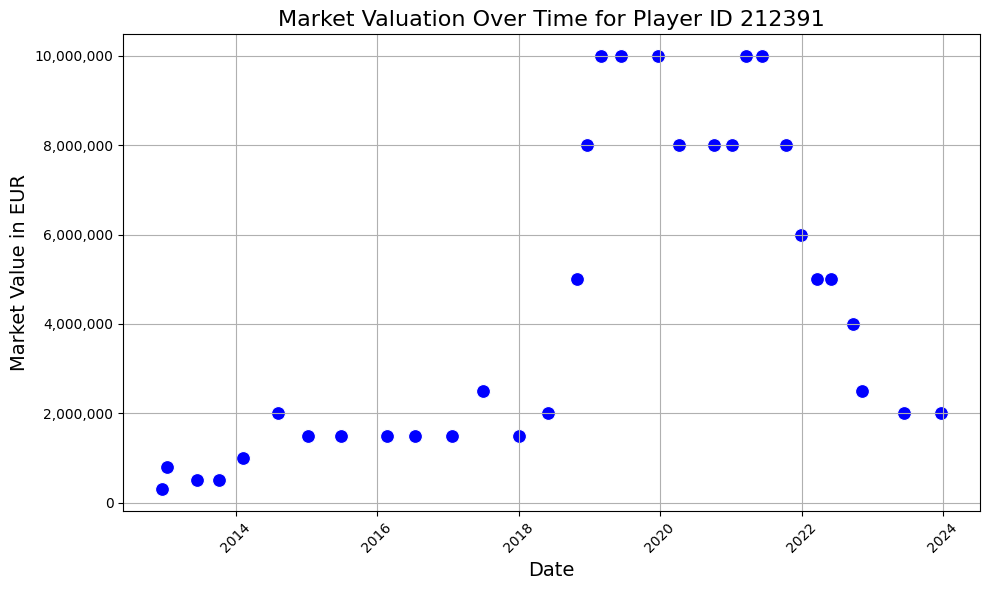

In [ ]:
plot_player_valuation_over_time(playervaluations, 212391)

In [ ]:
# only keeping the players with position == Attack
appearances = appearances[appearances['player_id'].isin(player_ids)]

# making date and year column to datetime type
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['year'] = appearances['date'].dt.year
appearances

<ipython-input-66-7ddd9d9d3fb5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appearances['date'] = pd.to_datetime(appearances['date'])
<ipython-input-66-7ddd9d9d3fb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appearances['year'] = appearances['date'].dt.year


,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played,year
101,2222962_73185,2222962,73185,2477,2687,2012-07-13,Lucas Pérez,UKR1,1,0,1,0,90,2012
438,2224730_95732,2224730,95732,3426,714,2012-07-15,Martin Braithwaite,DK1,0,0,0,0,90,2012
678,2222593_37834,2222593,37834,932,252,2012-07-20,Felipe Caicedo,RU1,0,0,0,0,9,2012
903,2222978_73185,2222978,73185,2477,2687,2012-07-21,Lucas Pérez,UKR1,1,0,0,0,90,2012
1290,2224568_95732,2224568,95732,3426,714,2012-07-23,Martin Braithwaite,DK1,0,0,0,0,90,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530166,4103699_94529,4103699,94529,12,12,2024-02-05,Stephan El Shaarawy,IT1,0,0,0,0,55,2024
1530167,4103699_96341,4103699,96341,12,12,2024-02-05,Romelu Lukaku,IT1,0,0,0,0,90,2024
1530201,4113038_162038,4113038,162038,367,367,2024-02-05,Raúl de Tomás,ES1,0,0,0,0,26,2024
1530203,4113038_189441,4113038,189441,368,368,2024-02-05,Lucas Ocampos,ES1,0,0,0,0,90,2024


In [ ]:
# Function to plot goals and valuations over time for a specific player
def plot_goals_and_valuation_with_fit(appearances_df, valuations_df, player_id):
    # Filter data for the specific player
    player_appearances = appearances_df[appearances_df['player_id'] == player_id]
    player_valuations = valuations_df[valuations_df['player_id'] == player_id]

    # Sorting data by date to ensure correct plotting order
    player_appearances.sort_values(by='date', inplace=True)
    player_valuations.sort_values(by='date', inplace=True)

    # Convert dates to ordinal numbers for regression analysis
    player_appearances['date_ordinal'] = player_appearances['date'].apply(lambda x: x.toordinal())
    player_valuations['date_ordinal'] = player_valuations['date'].apply(lambda x: x.toordinal())

    # Setup plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting goals on the first y-axis as transparent circle scatter
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Goals', color=color)
    ax1.scatter(player_appearances['date'], player_appearances['goals'], facecolors='none', edgecolors=color, alpha=0.5, s=100)
    ax1.tick_params(axis='y', labelcolor=color)

    # Fit and plot a line of best fit for goals
    if not player_appearances['goals'].empty:
        slope, intercept = np.polyfit(player_appearances['date_ordinal'], player_appearances['goals'], 1)
        ax1.plot(player_appearances['date'], slope * player_appearances['date_ordinal'] + intercept, color=color)

    # Create a second y-axis for market valuation
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Market Value in EUR', color=color)
    ax2.scatter(player_valuations['date'], player_valuations['market_value_in_eur'], color=color, marker='o', s=100)
    ax2.tick_params(axis='y', labelcolor=color)

    # Fit and plot a line of best fit for market value
    if not player_valuations['market_value_in_eur'].empty:
        slope, intercept = np.polyfit(player_valuations['date_ordinal'], player_valuations['market_value_in_eur'], 1)
        ax2.plot(player_valuations['date'], slope * player_valuations['date_ordinal'] + intercept, color=color)

    # Finalizing the plot
    plt.title(f'Goals and Market Valuation Over Time for Player ID {player_id}')
    plt.show()

<ipython-input-67-9b8941f5bc48>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_appearances.sort_values(by='date', inplace=True)
<ipython-input-67-9b8941f5bc48>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_valuations.sort_values(by='date', inplace=True)
<ipython-input-67-9b8941f5bc48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_appearances['date_or

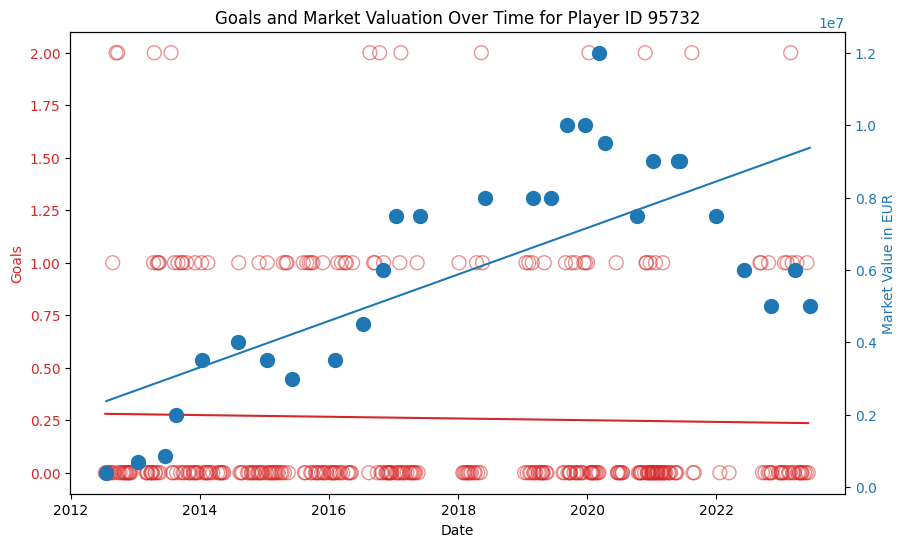

In [ ]:
plot_goals_and_valuation_with_fit(appearances, playervaluations, 95732)

In [ ]:
# only keeping the players with position == Attack
gamelineups = gamelineups[gamelineups['player_id'].isin(player_ids)]
gamelineups.head(5)

,game_lineups_id,game_id,club_id,type,number,player_id,player_name,team_captain,position
56,0e0e9bbf5babecd3372d01131fe71f40,2320446,27,starting_lineup,25,58358,Thomas Müller,0,Attacking Midfield
83,6329d1901c7bea0ca4d7a5d290853810,2320447,16,starting_lineup,9,38253,Robert Lewandowski,0,Centre-Forward
92,93e4a41acf7226c71a7f3fab6627a1c3,2320447,16,starting_lineup,17,58864,Pierre-Emerick Aubameyang,0,Right Winger
98,5043d3e78b38948f3be6f24fa9258ff8,2320447,16,substitutes,34,125103,Marvin Ducksch,0,Second Striker
150,98f137e84b12a9ea12b2ae05f8a6252e,2320449,533,starting_lineup,27,50512,Anthony Modeste,0,Centre-Forward


In [ ]:
#sportsref_stats.head()

In [ ]:
# changing the season column in the sportsref dataframe to datetime
# Extract the first year from the 'Season' column
#sportsref_stats['Season'] = sportsref_stats['Season'].str[:4]

# Convert the 'Season' column to datetime format, specifying the year starts on September 1st
#sportsref_stats['Season'] = pd.to_datetime(sportsref_stats['Season'] + '-09-01')


sportsref_stats['Player_id'] = pd.to_numeric(sportsref_stats['Player_id'], downcast='integer', errors='coerce')

# Optionally convert NaNs to a default value or handle them as needed
sportsref_stats['Player_id'].fillna(0, inplace=True)
sportsref_stats

<ipython-input-71-2bdf5dbd6cd4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sportsref_stats['Player_id'] = pd.to_numeric(sportsref_stats['Player_id'], downcast='integer', errors='coerce')
<ipython-input-71-2bdf5dbd6cd4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sportsref_stats['Player_id'].fillna(0, inplace=True)


,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,Ast,G+A,G-PK,PK,PKatt,PKm,Pos,FirstName,LastName,Player_id
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,"2,946",32.7,34,...,3,38,30,5,5,0,FW,Robert,Lewandowski,38253
1,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,"2,458",27.3,28,...,7,48,33,8,9,1,FW,Robert,Lewandowski,38253
2,Robert Lewandowski,30.7,2019-2020,30,Bayern Munich,de Bundesliga,31,"2,759",30.7,31,...,4,38,29,5,5,0,FW,Robert,Lewandowski,38253
3,Robert Lewandowski,30.7,2018-2019,29,Bayern Munich,de Bundesliga,33,"2,957",32.9,33,...,7,29,19,3,4,1,FW,Robert,Lewandowski,38253
6,Kylian Mbappé,28.0,2018-2019,19,Paris S-G,fr Ligue 1,29,"2,343",26.0,24,...,7,40,32,1,2,1,FW,Kylian,Mbappé,342229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,"1,717",19.1,16,...,1,10,6,3,3,0,"FW,MF",Luca,Waldschmidt,196095
991,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,"1,723",19.1,18,...,1,7,6,0,0,0,FW,Hendrik,Weydandt,330223
992,Iñaki Williams,7.3,2019-2020,25,Athletic Club,es La Liga,38,"2,939",32.7,34,...,1,7,5,1,2,1,FW,Iñaki,Williams,255508
993,Iñaki Williams,8.0,2023-2024,29,Athletic Club,es La Liga,28,"2,393",26.6,27,...,3,12,9,0,0,0,FW,Iñaki,Williams,255508


In [ ]:
# extracting the target variable - the valuation for each player per season
#appearances=appearances(['player_id','year','player_club_id'])
playerstats = playervaluations[['player_id', 'date', 'market_value_in_eur']]
playerstats['date'] = pd.to_datetime(playerstats['date'])
playerstats['year'] = playerstats['date'].dt.year
playerstats

<ipython-input-72-95f691dff0d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playerstats['date'] = pd.to_datetime(playerstats['date'])
<ipython-input-72-95f691dff0d1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playerstats['year'] = playerstats['date'].dt.year


,player_id,date,market_value_in_eur,year
77533,59323,2012-07-03,3000000,2012
77534,60890,2012-07-03,3000000,2012
77674,50202,2012-07-05,40000000,2012
77736,119037,2012-07-05,200000,2012
77741,125103,2012-07-05,600000,2012
...,...,...,...,...
464435,424784,2023-12-22,8000000,2023
464439,433049,2023-12-22,18000000,2023
464503,573775,2023-12-22,8000000,2023
464534,631002,2023-12-22,3000000,2023


In [ ]:
playerstats_1 = pd.merge(appearances, playerstats, left_on=['player_id', 'year'], right_on=['player_id', 'year'], how='inner')
playerstats_1['date'] = playerstats_1['date_y']
playerstats_1 = playerstats_1.drop(['appearance_id','player_name','game_id','player_current_club_id','date_x',
                                    'competition_id',	'yellow_cards',	'red_cards','goals','assists','minutes_played','date_y'], axis=1)


In [ ]:
playerstats_1

,player_id,player_club_id,year,market_value_in_eur,date
0,73185,2477,2012,2000000,2012-08-31
1,73185,2477,2012,3000000,2012-11-19
2,73185,2477,2012,2000000,2012-08-31
3,73185,2477,2012,3000000,2012-11-19
4,73185,2477,2012,2000000,2012-08-31
...,...,...,...,...,...
146482,333647,39,2023,7000000,2023-12-14
146483,333647,39,2023,12000000,2023-03-29
146484,333647,39,2023,10000000,2023-06-22
146485,333647,39,2023,7000000,2023-10-18


In [ ]:
##Merging the Two DataFrames

# The 'Season' column in df1 appears to be in a 'YYYY-YY' format. We need to extract the year from it
sportsref_stats['Season'] = sportsref_stats['Season'].astype(str)
sportsref_stats['year'] = sportsref_stats['Season'].str.split('-').str[0].astype(int)

# Merge the dataframes on 'player_id' and the extracted year
sports_df = pd.merge(sportsref_stats, playerstats_1, left_on=['Player_id', 'year'], right_on=['player_id', 'year'], how='inner')
sports_df = sports_df.drop_duplicates()

<ipython-input-75-a6c565b08829>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sportsref_stats['Season'] = sportsref_stats['Season'].astype(str)
<ipython-input-75-a6c565b08829>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sportsref_stats['year'] = sportsref_stats['Season'].str.split('-').str[0].astype(int)


In [ ]:
sports_df

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,PKm,Pos,FirstName,LastName,Player_id,year,player_id,player_club_id,market_value_in_eur,date
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,"2,946",32.7,34,...,0,FW,Robert,Lewandowski,38253,2021,38253,27,60000000,2021-02-10
1,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,"2,946",32.7,34,...,0,FW,Robert,Lewandowski,38253,2021,38253,27,60000000,2021-05-31
2,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,"2,946",32.7,34,...,0,FW,Robert,Lewandowski,38253,2021,38253,27,50000000,2021-12-22
141,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,"2,458",27.3,28,...,1,FW,Robert,Lewandowski,38253,2020,38253,27,56000000,2020-04-08
142,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,"2,458",27.3,28,...,1,FW,Robert,Lewandowski,38253,2020,38253,27,60000000,2020-09-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57485,Iñaki Williams,8.0,2023-2024,29,Athletic Club,es La Liga,28,"2,393",26.6,27,...,0,FW,Iñaki,Williams,255508,2023,255508,621,25000000,2023-06-13
57486,Iñaki Williams,8.0,2023-2024,29,Athletic Club,es La Liga,28,"2,393",26.6,27,...,0,FW,Iñaki,Williams,255508,2023,255508,621,25000000,2023-12-22
57573,Simone Zaza,7.5,2020-2021,29,Torino,it Serie A,29,"1,491",16.6,15,...,0,FW,Simone,Zaza,96828,2020,96828,416,7000000,2020-04-08
57574,Simone Zaza,7.5,2020-2021,29,Torino,it Serie A,29,"1,491",16.6,15,...,0,FW,Simone,Zaza,96828,2020,96828,416,6500000,2020-08-25


In [ ]:
##Keep only Valuations from April to October
sports_df['date'] = pd.to_datetime(sports_df['date'])
new_sports_df = sports_df[sports_df['date'].dt.month.between(4, 10)]
#new_sports_df = new_sports_df[(new_sports_df['market_value_in_eur']>300000)]

new_sports_df=new_sports_df.drop(['Pos','FirstName','LastName'],axis=1)
playerstats=new_sports_df
#Clean data
playerstats['Min'] = playerstats['Min'].str.replace(',', '').astype(float)
playerstats=playerstats.dropna()

playerstats

<ipython-input-77-f8b1491bbddb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sports_df['date'] = pd.to_datetime(sports_df['date'])


,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,G-PK,PK,PKatt,PKm,Player_id,year,player_id,player_club_id,market_value_in_eur,date
1,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,2946.0,32.7,34,...,30,5,5,0,38253,2021,38253,27,60000000,2021-05-31
141,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,33,8,9,1,38253,2020,38253,27,56000000,2020-04-08
142,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,33,8,9,1,38253,2020,38253,27,60000000,2020-09-16
221,Robert Lewandowski,30.7,2019-2020,30,Bayern Munich,de Bundesliga,31,2759.0,30.7,31,...,29,5,5,0,38253,2019,38253,27,65000000,2019-06-05
317,Robert Lewandowski,30.7,2018-2019,29,Bayern Munich,de Bundesliga,33,2957.0,32.9,33,...,19,3,4,1,38253,2018,38253,27,90000000,2018-04-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57319,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,6,0,0,0,330223,2018,330223,42,300000,2018-08-22
57366,Iñaki Williams,7.3,2019-2020,25,Athletic Club,es La Liga,38,2939.0,32.7,34,...,5,1,2,1,255508,2019,255508,621,50000000,2019-06-11
57485,Iñaki Williams,8.0,2023-2024,29,Athletic Club,es La Liga,28,2393.0,26.6,27,...,9,0,0,0,255508,2023,255508,621,25000000,2023-06-13
57573,Simone Zaza,7.5,2020-2021,29,Torino,it Serie A,29,1491.0,16.6,15,...,6,0,0,0,96828,2020,96828,416,7000000,2020-04-08


In [ ]:
#Check how many unique players
number_of_unique_players = playerstats['Player_id'].nunique()
print(f'There are {number_of_unique_players} unique players')

There are 232 unique players


In [ ]:
# adding the date to club games dataframe
clubgames = pd.read_csv('/content/drive/MyDrive/Football Stats/club_games.csv')
clubgames = pd.merge(clubgames, appearances[['game_id', 'date']].drop_duplicates(), on='game_id', how='left')

In [ ]:
# getting per season goals for each club
def assign_season(date):
    if pd.isna(date):
        return None  # Handle NaT values
    year = date.year
    if date.month >= 8:  # From August to December, the season ends next year
        return f"{year}-{year+1}"
    else:  # From January to May, the season ends in the same year
        return f"{year-1}-{year}"

# adding a season column
clubgames['season'] = clubgames['date'].apply(assign_season)

clubgoals_per_season = clubgames.groupby(['club_id', 'season'])['own_goals'].sum().reset_index()

In [ ]:
clubgoals_per_season

,club_id,season,own_goals
0,1,2013-2014,3
1,1,2019-2020,11
2,1,2023-2024,4
3,2,2013-2014,4
4,2,2017-2018,1
...,...,...,...
3432,102243,2023-2024,0
3433,102249,2022-2023,1
3434,102251,2022-2023,1
3435,111469,2023-2024,2


In [ ]:
clubs

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url
0,105,sv-darmstadt-98,Sportverein Darmstadt 1898 e. V.,L1,NaN,31,26.5,11,35.5,1,Merck-Stadion am Böllenfalltor,17810,€-1.48m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...
1,11127,ural-ekaterinburg,FK Ural Yekaterinburg,RU1,NaN,26,27.5,15,57.7,6,Yekaterinburg Arena,23000,€-775k,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/ural-ekaterinb...
2,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,NaN,31,27.3,15,48.4,12,Tüpraş Stadyumu,42590,€-14.50m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/besiktas-istan...
3,12,as-rom,Associazione Sportiva Roma,IT1,NaN,27,26.5,18,66.7,16,Olimpico di Roma,73261,+€63.00m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/as-rom/startse...
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,NaN,26,25.4,20,76.9,21,Tottenham Hotspur Stadium,62850,€-154.90m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/tottenham-hots...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,68608,cf-os-belenenses,CF Os Belenenses,PO1,NaN,30,25.7,5,16.7,0,Estádio do Restelo,19980,+-0,NaN,2017,../data/raw/transfermarkt-scraper/2017/clubs.j...,https://www.transfermarkt.co.uk/cf-os-belenens...
422,724,fc-volendam,Football Club Volendam,NL1,NaN,29,22.3,17,58.6,4,Kras Stadion,7384,+€2.30m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/fc-volendam/st...
423,800,atalanta-bergamo,Atalanta Bergamasca Calcio S.p.a.,IT1,NaN,25,26.9,18,72.0,16,Gewiss Stadium,21747,+€72.82m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/atalanta-berga...
424,979,moreirense-fc,Moreirense Futebol Clube,PO1,NaN,29,25.5,17,58.6,3,Estádio C. J. de Almeida Freitas,6153,€-2.05m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/moreirense-fc/...


In [ ]:
merged_clubs = pd.merge(clubs, clubgoals_per_season, on='club_id', how='inner')
merged_clubs

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url,season,own_goals
0,105,sv-darmstadt-98,Sportverein Darmstadt 1898 e. V.,L1,NaN,31,26.5,11,35.5,1,Merck-Stadion am Böllenfalltor,17810,€-1.48m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...,2013-2014,6
1,105,sv-darmstadt-98,Sportverein Darmstadt 1898 e. V.,L1,NaN,31,26.5,11,35.5,1,Merck-Stadion am Böllenfalltor,17810,€-1.48m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...,2015-2016,39
2,105,sv-darmstadt-98,Sportverein Darmstadt 1898 e. V.,L1,NaN,31,26.5,11,35.5,1,Merck-Stadion am Böllenfalltor,17810,€-1.48m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...,2016-2017,20
3,105,sv-darmstadt-98,Sportverein Darmstadt 1898 e. V.,L1,NaN,31,26.5,11,35.5,1,Merck-Stadion am Böllenfalltor,17810,€-1.48m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...,2018-2019,0
4,105,sv-darmstadt-98,Sportverein Darmstadt 1898 e. V.,L1,NaN,31,26.5,11,35.5,1,Merck-Stadion am Böllenfalltor,17810,€-1.48m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...,2022-2023,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,984,west-bromwich-albion,West Bromwich Albion,GB1,NaN,25,27.8,8,32.0,4,The Hawthorns,26850,€-1.35m,NaN,2020,../data/raw/transfermarkt-scraper/2020/clubs.j...,https://www.transfermarkt.co.uk/west-bromwich-...,2015-2016,11
2509,984,west-bromwich-albion,West Bromwich Albion,GB1,NaN,25,27.8,8,32.0,4,The Hawthorns,26850,€-1.35m,NaN,2020,../data/raw/transfermarkt-scraper/2020/clubs.j...,https://www.transfermarkt.co.uk/west-bromwich-...,2016-2017,16
2510,984,west-bromwich-albion,West Bromwich Albion,GB1,NaN,25,27.8,8,32.0,4,The Hawthorns,26850,€-1.35m,NaN,2020,../data/raw/transfermarkt-scraper/2020/clubs.j...,https://www.transfermarkt.co.uk/west-bromwich-...,2017-2018,20
2511,984,west-bromwich-albion,West Bromwich Albion,GB1,NaN,25,27.8,8,32.0,4,The Hawthorns,26850,€-1.35m,NaN,2020,../data/raw/transfermarkt-scraper/2020/clubs.j...,https://www.transfermarkt.co.uk/west-bromwich-...,2019-2020,1


Clean the Megred Clubs dataset

In [ ]:
merged_clubs=merged_clubs.drop(['club_code','domestic_competition_id','total_market_value',	'squad_size',	'average_age',	'foreigners_number',
                                'foreigners_percentage',	'national_team_players','stadium_name','stadium_seats','net_transfer_record',
                                'coach_name','last_season','filename','url'],axis=1)
merged_clubs['name'] = merged_clubs['name'].apply(lambda x: ' '.join(x.split()[:2]) if pd.notnull(x) else x)
merged_clubs['season'] = merged_clubs['season'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else x)

merged_clubs

,club_id,name,season,own_goals
0,105,Sportverein Darmstadt,2013,6
1,105,Sportverein Darmstadt,2015,39
2,105,Sportverein Darmstadt,2016,20
3,105,Sportverein Darmstadt,2018,0
4,105,Sportverein Darmstadt,2022,4
...,...,...,...,...
2508,984,West Bromwich,2015,11
2509,984,West Bromwich,2016,16
2510,984,West Bromwich,2017,20
2511,984,West Bromwich,2019,1


In [ ]:
# making the season datetime
def extract_season_dates(season):
    if season:
        start_year, end_year = map(int, season.split('-'))
        # Soccer season starts on August 1st of the start year and ends on May 31st of the end year
        season_start_date = pd.Timestamp(year=start_year, month=8, day=1)
        season_end_date = pd.Timestamp(year=end_year, month=5, day=31)
        return season_start_date, season_end_date
    return None, None

# Apply the function and create new columns
clubgoals_per_season['season_start_date'], clubgoals_per_season['season_end_date'] = zip(*clubgoals_per_season['season'].apply(extract_season_dates))


In [ ]:
clubgoals_per_season

,club_id,season,own_goals,season_start_date,season_end_date
0,1,2013-2014,3,2013-08-01,2014-05-31
1,1,2019-2020,11,2019-08-01,2020-05-31
2,1,2023-2024,4,2023-08-01,2024-05-31
3,2,2013-2014,4,2013-08-01,2014-05-31
4,2,2017-2018,1,2017-08-01,2018-05-31
...,...,...,...,...,...
3432,102243,2023-2024,0,2023-08-01,2024-05-31
3433,102249,2022-2023,1,2022-08-01,2023-05-31
3434,102251,2022-2023,1,2022-08-01,2023-05-31
3435,111469,2023-2024,2,2023-08-01,2024-05-31


In [ ]:
clubgames = clubgames.dropna(subset=['date'])

In [ ]:
# adding a season start and end date
clubgames['season_start_date'], clubgames['season_end_date'] = zip(*clubgames['season'].apply(extract_season_dates))

In [ ]:
# finding the goals per season on a game by game basis and adding them up across the season
clubgames_sorted = clubgames.sort_values(by=['club_id', 'date'])

# Calculate cumulative goals in clubgames, ensuring to subtract current match goals to align historical data correctly
clubgames_sorted['cumulative_goals'] = clubgames_sorted.groupby(['club_id', 'season_start_date'])['own_goals'].cumsum()

In [ ]:
clubgames = clubgames_sorted

In [ ]:
clubgames

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win,date,season,season_start_date,season_end_date,cumulative_goals
1,2320460,1,3,NaN,Jürgen Luginger,86,1,NaN,Robin Dutt,Home,1,2013-08-04,2013-2014,2013-08-01,2014-05-31,3
8358,2370752,1,0,NaN,Milan Sasic,16,2,NaN,Jürgen Klopp,Home,0,2013-12-03,2013-2014,2013-08-01,2014-05-31,3
11595,3245513,1,3,NaN,Dirk Lottner,3,2,NaN,Achim Beierlorzer,Home,1,2019-10-29,2019-2020,2019-08-01,2020-05-31,3
44393,3319622,1,8,NaN,Lukas Kwasniok,38,7,NaN,Uwe Rösler,Home,1,2020-03-03,2019-2020,2019-08-01,2020-05-31,11
14871,3332669,1,0,NaN,Lukas Kwasniok,15,3,NaN,Peter Bosz,Home,0,2020-06-09,2019-2020,2019-08-01,2020-05-31,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32469,4204000,102243,0,NaN,Paco Maroto,940,4,NaN,Rafael Benítez,Home,0,2023-11-01,2023-2024,2023-08-01,2024-05-31,0
23789,3949571,102249,1,NaN,NaN,331,4,NaN,NaN,Home,0,2022-11-12,2022-2023,2022-08-01,2023-05-31,1
48344,3949573,102251,1,NaN,NaN,681,4,NaN,NaN,Home,0,2022-11-13,2022-2023,2022-08-01,2023-05-31,1
56951,4204006,111469,2,NaN,Ferran Costa,2687,4,NaN,Sergio,Home,0,2023-11-01,2023-2024,2023-08-01,2024-05-31,2


Connecting Megred_Clubs and Playerstats

In [ ]:
merged_clubs['name'] = merged_clubs['name'].apply(lambda x: ' '.join(x.split()[:1]) if pd.notnull(x) else x)
merged_clubs['season'] = merged_clubs['season'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else x)
merged_clubs

,club_id,name,season,own_goals
0,105,Sportverein,2013,6
1,105,Sportverein,2015,39
2,105,Sportverein,2016,20
3,105,Sportverein,2018,0
4,105,Sportverein,2022,4
...,...,...,...,...
2508,984,West,2015,11
2509,984,West,2016,16
2510,984,West,2017,20
2511,984,West,2019,1


In [ ]:
playerstats

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,G-PK,PK,PKatt,PKm,Player_id,year,player_id,player_club_id,market_value_in_eur,date
1,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,2946.0,32.7,34,...,30,5,5,0,38253,2021,38253,27,60000000,2021-05-31
141,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,33,8,9,1,38253,2020,38253,27,56000000,2020-04-08
142,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,33,8,9,1,38253,2020,38253,27,60000000,2020-09-16
221,Robert Lewandowski,30.7,2019-2020,30,Bayern Munich,de Bundesliga,31,2759.0,30.7,31,...,29,5,5,0,38253,2019,38253,27,65000000,2019-06-05
317,Robert Lewandowski,30.7,2018-2019,29,Bayern Munich,de Bundesliga,33,2957.0,32.9,33,...,19,3,4,1,38253,2018,38253,27,90000000,2018-04-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57319,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,6,0,0,0,330223,2018,330223,42,300000,2018-08-22
57366,Iñaki Williams,7.3,2019-2020,25,Athletic Club,es La Liga,38,2939.0,32.7,34,...,5,1,2,1,255508,2019,255508,621,50000000,2019-06-11
57485,Iñaki Williams,8.0,2023-2024,29,Athletic Club,es La Liga,28,2393.0,26.6,27,...,9,0,0,0,255508,2023,255508,621,25000000,2023-06-13
57573,Simone Zaza,7.5,2020-2021,29,Torino,it Serie A,29,1491.0,16.6,15,...,6,0,0,0,96828,2020,96828,416,7000000,2020-04-08


In [ ]:
playerstats.dtypes

Player                         object
xG                            float64
Season                         object
Age                             int64
Team                           object
Comp                           object
MP                              int64
Min                           float64
90s                           float64
Starts                          int64
Subs                            int64
unSub                           int64
xG.1                          float64
npxG                          float64
xAG                           float64
xG+xAG                        float64
xA                            float64
npxG+xAG                      float64
G-xG                          float64
np:G-xG                       float64
A-xAG                         float64
npxG/Sh                       float64
Sh                              int64
G/Sh                          float64
G/SoT                         float64
SoT                             int64
SoT%        

In [ ]:
merged_clubs['season'] = merged_clubs['season'].astype(str)
playerstats['year'] = playerstats['year'].astype(str)
playerstats__df = pd.merge(playerstats, merged_clubs, left_on=['player_club_id','year'], right_on=['club_id','season'], how='inner')
playerstats__df

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,Player_id,year,player_id,player_club_id,market_value_in_eur,date,club_id,name,season,own_goals
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,2946.0,32.7,34,...,38253,2021,38253,27,60000000,2021-05-31,27,FC,2021,148
1,Leroy Sané,11.4,2021-2022,25,Bayern Munich,de Bundesliga,32,1976.0,22.0,22,...,192565,2021,192565,27,60000000,2021-06-01,27,FC,2021,148
2,Serge Gnabry,8.5,2021-2022,26,Bayern Munich,de Bundesliga,34,2185.0,24.3,25,...,159471,2021,159471,27,70000000,2021-06-01,27,FC,2021,148
3,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,38253,2020,38253,27,56000000,2020-04-08,27,FC,2020,160
4,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,38253,2020,38253,27,60000000,2020-09-16,27,FC,2020,160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,1717.0,19.1,16,...,196095,2018,196095,60,2500000,2018-06-05,60,Sport-Club,2018,54
1060,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,1717.0,19.1,16,...,196095,2018,196095,60,4000000,2018-08-22,60,Sport-Club,2018,54
1061,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,330223,2018,330223,42,150000,2018-08-08,42,Hannover,2018,37
1062,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,330223,2018,330223,42,300000,2018-08-22,42,Hannover,2018,37


In [ ]:
## Engineering player contribution
playerstats__df['Contribution'] = np.where(playerstats__df['own_goals'] != 0, playerstats__df['G+A'] / playerstats__df['own_goals'],0)
playerstats__df

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,year,player_id,player_club_id,market_value_in_eur,date,club_id,name,season,own_goals,Contribution
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,2946.0,32.7,34,...,2021,38253,27,60000000,2021-05-31,27,FC,2021,148,0.256757
1,Leroy Sané,11.4,2021-2022,25,Bayern Munich,de Bundesliga,32,1976.0,22.0,22,...,2021,192565,27,60000000,2021-06-01,27,FC,2021,148,0.094595
2,Serge Gnabry,8.5,2021-2022,26,Bayern Munich,de Bundesliga,34,2185.0,24.3,25,...,2021,159471,27,70000000,2021-06-01,27,FC,2021,148,0.128378
3,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,2020,38253,27,56000000,2020-04-08,27,FC,2020,160,0.300000
4,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,2020,38253,27,60000000,2020-09-16,27,FC,2020,160,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,1717.0,19.1,16,...,2018,196095,60,2500000,2018-06-05,60,Sport-Club,2018,54,0.185185
1060,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,1717.0,19.1,16,...,2018,196095,60,4000000,2018-08-22,60,Sport-Club,2018,54,0.185185
1061,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,2018,330223,42,150000,2018-08-08,42,Hannover,2018,37,0.189189
1062,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,2018,330223,42,300000,2018-08-22,42,Hannover,2018,37,0.189189


API Feature Engineering

In [ ]:
# using an API to engineer features
# ran the API and saved the data to a csv to prevent running the API over and over

'''
#Convert Value to millions
def convert_to_millions(value):
    if isinstance(value, str) and not value.replace(',', '').replace('.', '').isdigit():
        return 0.0

    elif ',' in value:
        return float(value.replace(',', '.'))

    elif isinstance(value, str):
        return float(value) / 1000

    elif isinstance(value, (int, float)):
        return value / 1000
    else:
        return 0.0


#Transfer History Per Player
def transfer_history(player_id):
    player_id = player_id
    url = 'https://transfermarket.p.rapidapi.com/players/get-transfer-history'
    params = {'id': f'{player_id}', 'domain': 'com'}
    headers = {
        'X-RapidAPI-Key': '5464c75491msha53c005443435c7p182068jsnfbea14530413',
        'X-RapidAPI-Host': 'transfermarket.p.rapidapi.com'
    }
    response = requests.get(url, headers=headers, params=params)

    player_data = response.json()
    transfer_data = []
    for row in player_data['transferHistory']:
        transfer_data.append({
            'Season': row['season'],
            'Date': row['date'],
            'Old Club': row['oldClubName'],
            'New Club': row['newClubName'],
            'Fee': row['transferFeeValue']
        })

    transfer_df = pd.DataFrame(transfer_data)
    transfer_df['Fee'] = transfer_df['Fee'].apply(convert_to_millions)
    return transfer_df

#Achievements Per Player
def player_achievements(player_id):
  player_id=player_id
  url= 'https://transfermarket.p.rapidapi.com/players/get-achievements'
  params = {'id': f'{player_id}',
            'domain': 'com'}
  headers = {
    'X-RapidAPI-Key': '5464c75491msha53c005443435c7p182068jsnfbea14530413',
    'X-RapidAPI-Host': 'transfermarket.p.rapidapi.com'
  }
  response = requests.get(url, params=params, headers=headers)

  player_achievement = response.json()
  achievements_expanded = []
  for achievement in player_achievement['playerAchievements']:
        for detail in achievement['additionalData']:
            achievements_expanded.append({
                'competition_id': detail['competitionID'],
                'title': achievement['title'],
                'count': achievement['value'],
                'detail_season_id': detail['seasonID'],
                'detail_club_id': detail['clubID']
            })

  achievements_df = pd.DataFrame(achievements_expanded)

  achievements_df['count'] = achievements_df['count'].str.replace('x', '').astype(int)
  achievements_df = achievements_df.groupby('detail_season_id')['count'].sum().reset_index()

  return achievements_df

#Player Value History
def player_market_value(player_id):
    player_id = player_id
    url = 'https://transfermarket.p.rapidapi.com/players/get-market-value'
    params = {'id': f'{player_id}', 'domain': 'com'}
    headers = {
        'X-RapidAPI-Key': '5464c75491msha53c005443435c7p182068jsnfbea14530413',
        'X-RapidAPI-Host': 'transfermarket.p.rapidapi.com'
    }
    response = requests.get(url, params=params, headers=headers)

    player_value = response.json()
    market_value_df = pd.DataFrame(player_value['marketValueDevelopment'])
    market_value_df = market_value_df.drop(['date', 'marketValueUnformatted', 'marketValueCurrency',
                                            'marketValueNumeral', 'clubImage', 'clubShortName'], axis=1)
    market_value_df = market_value_df.rename(columns={'unformattedDate': 'Date'})
    market_value_df['marketValue'] = market_value_df['marketValue'].apply(convert_to_millions)

    cols = market_value_df.columns.tolist()
    cols = [cols[-1]] + cols[:-1]
    market_value_df = market_value_df[cols]

    return market_value_df
    '''

"\n#Convert Value to millions\ndef convert_to_millions(value):\n    if isinstance(value, str) and not value.replace(',', '').replace('.', '').isdigit():\n        return 0.0\n\n    elif ',' in value:\n        return float(value.replace(',', '.'))\n\n    elif isinstance(value, str):\n        return float(value) / 1000\n\n    elif isinstance(value, (int, float)):\n        return value / 1000\n    else:\n        return 0.0\n\n\n#Transfer History Per Player\ndef transfer_history(player_id):\n    player_id = player_id\n    url = 'https://transfermarket.p.rapidapi.com/players/get-transfer-history'\n    params = {'id': f'{player_id}', 'domain': 'com'}\n    headers = {\n        'X-RapidAPI-Key': '5464c75491msha53c005443435c7p182068jsnfbea14530413',\n        'X-RapidAPI-Host': 'transfermarket.p.rapidapi.com'\n    }\n    response = requests.get(url, headers=headers, params=params)\n\n    player_data = response.json()\n    transfer_data = []\n    for row in player_data['transferHistory']:\n       

In [ ]:
# ran the API and saved the data to a csv to prevent running the API over and over
'''
#Engineering Player Achievements
import time

#player_ids=playerstats__df['player_id']
achievements=[]


for player_id in playerstats__df['player_id'].unique():
  try:
    achievements_df=player_achievements(player_id)
    if not achievements_df.empty:
      achievements_df['player_id'] = player_id
      achievements.append(achievements_df)
  except:
    achievements_df = pd.DataFrame({'detail_season_id': [pd.NaT], 'count': [0], 'player_id': [player_id]})
    achievements.append(achievements_df)

all_achievements_df = pd.concat(achievements, ignore_index=True)
'''

"\n#Engineering Player Achievements\nimport time\n\n#player_ids=playerstats__df['player_id']\nachievements=[]\n\n\nfor player_id in playerstats__df['player_id'].unique():\n  try:\n    achievements_df=player_achievements(player_id)\n    if not achievements_df.empty:\n      achievements_df['player_id'] = player_id\n      achievements.append(achievements_df)\n  except:\n    achievements_df = pd.DataFrame({'detail_season_id': [pd.NaT], 'count': [0], 'player_id': [player_id]})\n    achievements.append(achievements_df)\n\nall_achievements_df = pd.concat(achievements, ignore_index=True)\n"

In [ ]:
# merging data from above
# cell should not be run - data saved to a csv
'''
playerstats_df_2 = pd.merge(playerstats__df, all_achievements_df, left_on=['player_id','year'], right_on=['player_id','detail_season_id'], how='left')
#playerstats_df_2 = pd.merge(playerstats__df, all_achievements_df, on=['player_id'], how='left', suffixes=('_val', '_ach'))
playerstats_df_2['count'].fillna(0, inplace=True)
playerstats_df_2
'''

"\nplayerstats_df_2 = pd.merge(playerstats__df, all_achievements_df, left_on=['player_id','year'], right_on=['player_id','detail_season_id'], how='left')\n#playerstats_df_2 = pd.merge(playerstats__df, all_achievements_df, on=['player_id'], how='left', suffixes=('_val', '_ach'))\nplayerstats_df_2['count'].fillna(0, inplace=True)\nplayerstats_df_2\n"

In [ ]:
# cell should not be run - data saved to a csv
'''playerstats_df_2.rename(columns={'count':'achievement_count'}, inplace=True)'''

"playerstats_df_2.rename(columns={'count':'achievement_count'}, inplace=True)"

In [ ]:
# turning the dataframe from above to a csv to prevent running the API again
'''playerstats_df_2.to_csv('playerstats_df_2.csv', index=False)  # Set index=False to avoid writing row indices to the CSV file'''

"playerstats_df_2.to_csv('playerstats_df_2.csv', index=False)  # Set index=False to avoid writing row indices to the CSV file"

In [ ]:
playerstats_df_2 = pd.read_csv('/content/drive/MyDrive/Football Stats/playerstats_df_2.csv')

In [ ]:
playerstats_df_2

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,player_club_id,market_value_in_eur,date,club_id,name,season,own_goals,Contribution,detail_season_id,achievement_count
0,Robert Lewandowski,33.2,2021-2022,32,Bayern Munich,de Bundesliga,34,2946.0,32.7,34,...,27,60000000,2021-05-31,27,FC,2021,148,0.256757,2021.0,52.0
1,Leroy Sané,11.4,2021-2022,25,Bayern Munich,de Bundesliga,32,1976.0,22.0,22,...,27,60000000,2021-06-01,27,FC,2021,148,0.094595,2021.0,13.0
2,Serge Gnabry,8.5,2021-2022,26,Bayern Munich,de Bundesliga,34,2185.0,24.3,25,...,27,70000000,2021-06-01,27,FC,2021,148,0.128378,2021.0,17.0
3,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,27,56000000,2020-04-08,27,FC,2020,160,0.300000,2020.0,85.0
4,Robert Lewandowski,31.3,2020-2021,31,Bayern Munich,de Bundesliga,29,2458.0,27.3,28,...,27,60000000,2020-09-16,27,FC,2020,160,0.300000,2020.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,1717.0,19.1,16,...,60,2500000,2018-06-05,60,Sport-Club,2018,54,0.185185,2018.0,2.0
1060,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,1717.0,19.1,16,...,60,4000000,2018-08-22,60,Sport-Club,2018,54,0.185185,2018.0,2.0
1061,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,42,150000,2018-08-08,42,Hannover,2018,37,0.189189,NaN,0.0
1062,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,42,300000,2018-08-22,42,Hannover,2018,37,0.189189,NaN,0.0


In [ ]:
playerstats_df_2_=playerstats_df_2[playerstats_df_2['market_value_in_eur']<3000000]
playerstats_df_2_

,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,player_club_id,market_value_in_eur,date,club_id,name,season,own_goals,Contribution,detail_season_id,achievement_count
93,Fabio Quagliarella,21.9,2018-2019,35,Sampdoria,it Serie A,37,3199.0,35.5,37,...,1038,2000000,2018-06-07,1038,UC,2018,63,0.539683,2018.0,2.0
145,Florian Sotoca,10.5,2022-2023,31,Lens,fr Ligue 1,38,3054.0,33.9,34,...,826,2500000,2022-05-30,826,Racing,2022,68,0.235294,NaN,0.0
149,Fabio Quagliarella,18.3,2017-2018,34,Sampdoria,it Serie A,35,2719.0,30.2,33,...,1038,2000000,2017-06-08,1038,UC,2017,65,0.369231,NaN,0.0
163,Anthony Modeste,18.0,2021-2022,33,Köln,de Bundesliga,32,2606.0,29.0,31,...,3,2000000,2021-04-09,3,1.,2021,68,0.352941,NaN,0.0
164,Anthony Modeste,18.0,2021-2022,33,Köln,de Bundesliga,32,2606.0,29.0,31,...,3,1500000,2021-06-04,3,1.,2021,68,0.352941,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,Phillip Tietz,7.6,2023-2024,26,Augsburg,de Bundesliga,29,2035.0,22.6,26,...,167,2700000,2023-06-28,167,FC,2023,29,0.413793,NaN,0.0
1057,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,1717.0,19.1,16,...,41,2500000,2018-06-05,41,Hamburger,2018,1,10.000000,2018.0,2.0
1059,Luca Waldschmidt,7.9,2018-2019,22,Freiburg,de Bundesliga,30,1717.0,19.1,16,...,60,2500000,2018-06-05,60,Sport-Club,2018,54,0.185185,2018.0,2.0
1061,Hendrik Weydandt,8.0,2018-2019,23,Hannover 96,de Bundesliga,28,1723.0,19.1,18,...,42,150000,2018-08-08,42,Hannover,2018,37,0.189189,NaN,0.0


In [ ]:
playerstats_df_2.dtypes

Player                  object
xG                     float64
Season                  object
Age                      int64
Team                    object
Comp                    object
MP                       int64
Min                    float64
90s                    float64
Starts                   int64
Subs                     int64
unSub                    int64
xG.1                   float64
npxG                   float64
xAG                    float64
xG+xAG                 float64
xA                     float64
npxG+xAG               float64
G-xG                   float64
np:G-xG                float64
A-xAG                  float64
npxG/Sh                float64
Sh                       int64
G/Sh                   float64
G/SoT                  float64
SoT                      int64
SoT%                   float64
Dist                   float64
FK                       int64
Gls                      int64
Ast                      int64
G+A                      int64
G-PK    

In [ ]:
## Baseline
baseline_data = playerstats_df_2[['Player_id', 'date', 'Gls', 'market_value_in_eur']]
baseline_data

,Player_id,date,Gls,market_value_in_eur
0,38253,2021-05-31,35,60000000
1,192565,2021-06-01,7,60000000
2,159471,2021-06-01,14,70000000
3,38253,2020-04-08,41,56000000
4,38253,2020-09-16,41,60000000
...,...,...,...,...
1059,196095,2018-06-05,9,2500000
1060,196095,2018-08-22,9,4000000
1061,330223,2018-08-08,6,150000
1062,330223,2018-08-22,6,300000


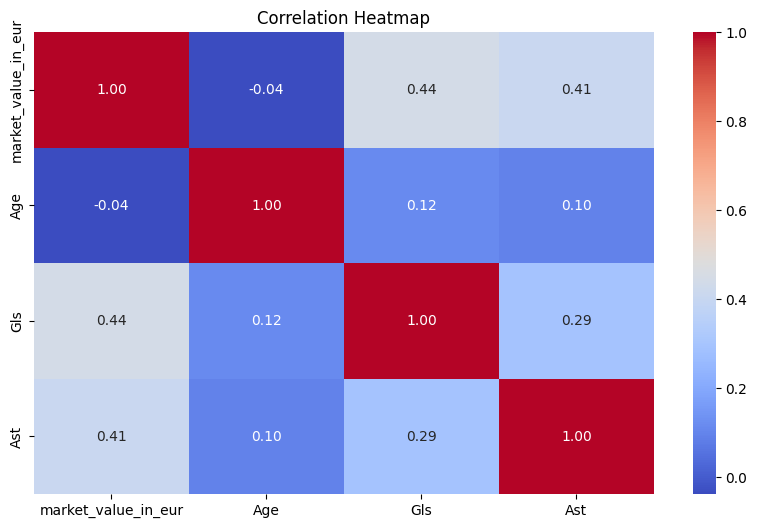

In [ ]:

correlation_matrix = playerstats_df_2[['market_value_in_eur', 'Age', 'Gls', 'Ast']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Player Stats Anaylsis versus Market Value

Market Value vs Achievemtns and game exposure

<ipython-input-6-dda545ac8cca>:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable, label='Total Goal Contriutions (Assists + Goals Without Penalties))')


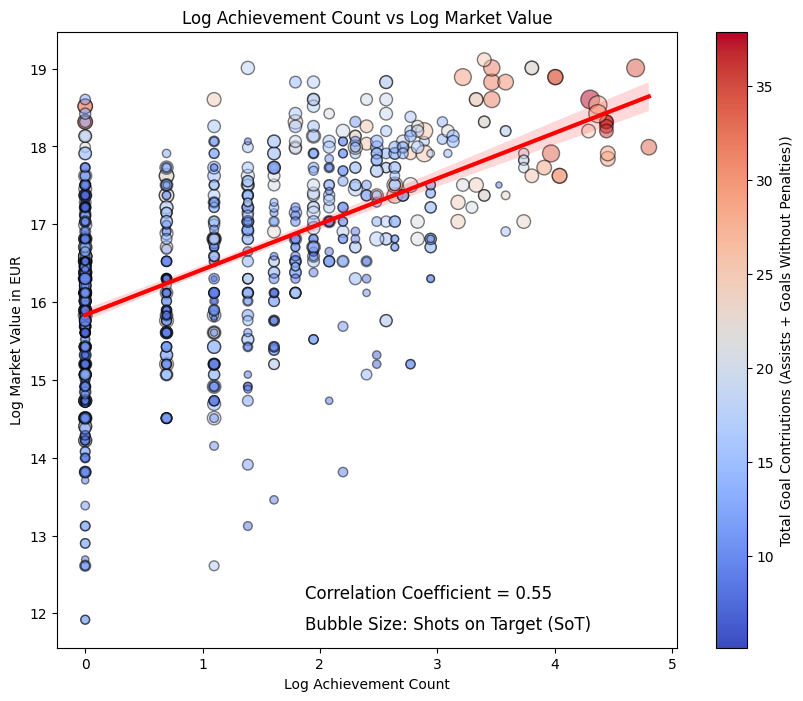

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


x = playerstats_df_2['achievement_count']
y = playerstats_df_2['market_value_in_eur']
sizes = playerstats_df_2['SoT'] * 2
colors = playerstats_df_2['npxG+xAG']


x_log = np.log(x + 1)
y_log = np.log(y + 1)


correlation, _ = scipy.stats.pearsonr(x_log, y_log)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_log, y_log, s=sizes, c=colors, cmap='coolwarm', alpha=0.5, edgecolor='black')
sns.regplot(x=x_log, y=y_log, scatter=False, color='red', line_kws={"linewidth": 3})

plt.title('Log Achievement Count vs Log Market Value')
plt.xlabel('Log Achievement Count')
plt.ylabel('Log Market Value in EUR')
plt.annotate(f'Correlation Coefficient = {correlation:.2f}', xy=(0.4, 0.08), xycoords='axes fraction', fontsize=12, backgroundcolor='white')
plt.annotate('Bubble Size: Shots on Target (SoT)', xy=(0.4, 0.03), xycoords='axes fraction', fontsize=12, backgroundcolor='white')


norm = Normalize(vmin=min(colors), vmax=max(colors))
mappable = ScalarMappable(norm=norm, cmap='coolwarm')
mappable.set_array(colors)
cbar = plt.colorbar(mappable, label='Total Goal Contriutions (Assists + Goals Without Penalties))')

plt.show()

Market Value vs. Level of Skill

<ipython-input-7-9c05145e247b>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable, label='Distance of Goal Scored (m)')


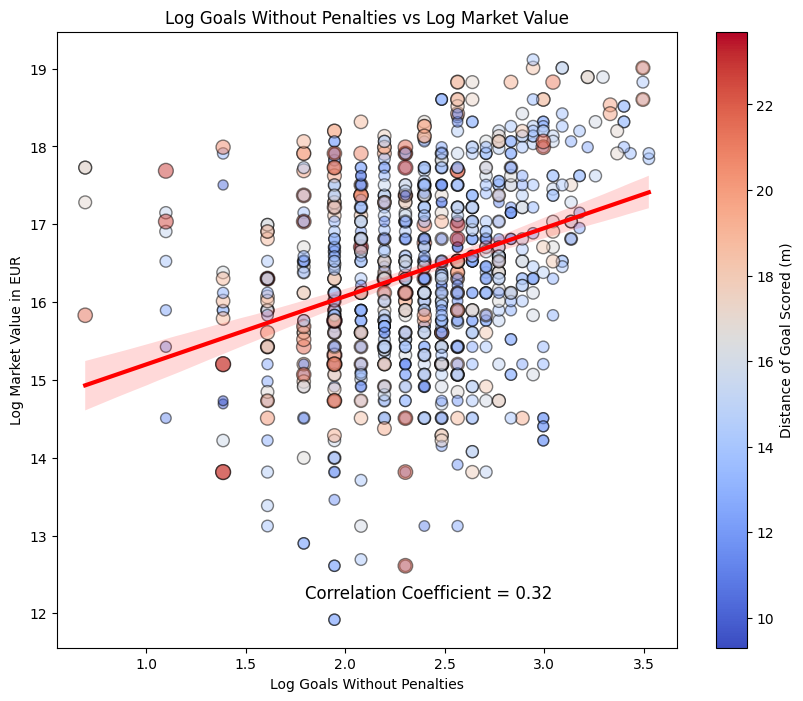

In [ ]:
x = playerstats_df_2['G-PK']
y = playerstats_df_2['market_value_in_eur']
sizes = playerstats_df_2['Dist'] * 5
colors = playerstats_df_2['Dist']


x_log = np.log(x + 1)
y_log = np.log(y + 1)


correlation, _ = scipy.stats.pearsonr(x_log, y_log)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_log, y_log, s=sizes, c=colors, cmap='coolwarm', alpha=0.5, edgecolor='black')
sns.regplot(x=x_log, y=y_log, scatter=False, color='red', line_kws={"linewidth": 3})

plt.title('Log Goals Without Penalties vs Log Market Value')
plt.xlabel('Log Goals Without Penalties')
plt.ylabel('Log Market Value in EUR')
plt.annotate(f'Correlation Coefficient = {correlation:.2f}', xy=(0.4, 0.08), xycoords='axes fraction', fontsize=12, backgroundcolor='white')



norm = Normalize(vmin=min(colors), vmax=max(colors))
mappable = ScalarMappable(norm=norm, cmap='coolwarm')
mappable.set_array(colors)
cbar = plt.colorbar(mappable, label='Distance of Goal Scored (m)')

plt.show()

# **Modeling**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Splitting the dataset into training and testing sets
X = baseline_data[['Gls']]  # Predictor
y = baseline_data['market_value_in_eur']  # Response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)



# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate R2 and RMSE
r2_base = r2_score(y_test, y_pred)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred))

# Display the results
print("Baseline Model - SLR")
print("R^2: {:.2f}".format(r2_base))
print("RMSE: {:.2f}".format(rmse_base))


Baseline Model - SLR
R^2: 0.19
RMSE: 26249194.34


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


features = ['achievement_count','Contribution','xG', 'Age', 'MP',	'Min','90s','Starts',	'Subs',	'unSub',	'xG',	'npxG',	'xAG','xG+xAG',	'xA',	'npxG+xAG',	'G-xG',	'np:G-xG',	'A-xAG',	'npxG/Sh',	'Sh',	'G/Sh',	'G/SoT','SoT','SoT%','Dist','FK','Gls','Ast',	'G+A','G-PK','PK','PKatt','PKm']
X = playerstats_df_2[features]
y = playerstats_df_2['market_value_in_eur']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Calculating R2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Displaying the results
print("Multiple Linear Regression")
print("RMSE: {:.2f}".format(rmse))
print("R^2: {:.2f}".format(r2))

Multiple Linear Regression
RMSE: 21565129.79
R^2: 0.45


In [ ]:
# principal component analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming playerstats is already loaded and selected with relevant numeric features
X = playerstats_df_2[features]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=5)  # Adjust the number of components based on your analysis
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Rounding the metrics to 2 decimal places
rmse_rounded = round(rmse, 2)
r2_rounded = round(r2, 2)

# Display the results
print("Principal Components Analysis")
print(f"Root Mean Squared Error: {rmse_rounded}")
print(f"R^2 Score: {r2_rounded}")

Principal Components Analysis
Root Mean Squared Error: 22619051.51
R^2 Score: 0.4


In [ ]:
# lasso and ridge regression - finding optimized hyper parameters
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge

# Define the parameter grid for Lasso and Ridge
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize the Lasso and Ridge models
lasso = Lasso()
ridge = Ridge()

# Set up the GridSearchCV for Lasso
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
# Set up the GridSearchCV for Ridge
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42) # using X_scaled from above model

# Fit the grid search to the training data
lasso_grid.fit(X_train, y_train)
ridge_grid.fit(X_train, y_train)

# Get the best alpha values
best_alpha_lasso = lasso_grid.best_params_['alpha']
best_alpha_ridge = ridge_grid.best_params_['alpha']

print("Best alpha for Lasso:", best_alpha_lasso)
print("Best alpha for Ridge:", best_alpha_ridge)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+17, tolerance: 5.974e+13
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+17, tolerance: 5.715e+13
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e+17, tolerance: 5.832e

Best alpha for Lasso: 100
Best alpha for Ridge: 100


In [ ]:
# lasso and ridge regression - predictive model
# Initialize the models with the best parameters
lasso_best = Lasso(alpha=best_alpha_lasso)
ridge_best = Ridge(alpha=best_alpha_ridge)

# Train the models
lasso_best.fit(X_train, y_train)
ridge_best.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_best.predict(X_test)
y_pred_ridge = ridge_best.predict(X_test)

# Calculate RMSE and R^2
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Display the results rounded to two decimal places
print("Optimized Lasso Regression:")
print(f"RMSE: {round(rmse_lasso, 2)}")
print(f"R^2: {round(r2_lasso, 2)}")

print("\nOptimized Ridge Regression:")
print(f"RMSE: {round(rmse_ridge, 2)}")
print(f"R^2: {round(r2_ridge, 2)}")


Optimized Lasso Regression:
RMSE: 21741309.21
R^2: 0.44

Optimized Ridge Regression:
RMSE: 21812963.49
R^2: 0.44


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e+17, tolerance: 7.325e+13
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# random forest regressor - optimized parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# X and y are already defined

# Sample a subset of the data for quicker hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9, random_state=42)

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],  # Reduced number of trees options
    'max_features': ['auto'],    # Most common option for classification
    'max_depth': [10, 20]        # Simplified depth options
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Set up the RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                      n_iter=10,  # Number of parameter settings sampled
                                      cv=3,       # Reduced number of folds
                                      scoring='neg_mean_squared_error',
                                      n_jobs=-1,
                                      random_state=42,
                                      verbose=2)

# Fit random search to the scaled subset of data
random_search_rf.fit(X_sample_scaled, y_sample)

# Get the best estimator
best_rf = random_search_rf.best_estimator_

# Now use the best model found to predict on the full dataset
# First, prepare the full dataset for prediction
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the best Random Forest model
best_rf.fit(X_train, y_train)

# Make predictions with the best model
y_pred_rf = best_rf.predict(X_test)

# Calculate RMSE and R^2
rmse_rf_1 = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf_1 = r2_score(y_test, y_pred_rf)

# Print the performance metrics rounded to two decimal places
print(f"Optimized Random Forest Regressor")
print(f"RMSE: {round(rmse_rf_1, 2)}")
print(f"R^2: {round(r2_rf_1, 2)}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Optimized Random Forest Regressor
RMSE: 15066443.63
R^2: 0.73


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# X and y are already defined

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the KNN regressor
knn = KNeighborsRegressor()

# Set up GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3,
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit grid search to the scaled training data
grid_search_knn.fit(X_train_scaled, y_train)

# Get the best estimator
best_knn = grid_search_knn.best_estimator_

# Make predictions with the best model
y_pred_knn = best_knn.predict(X_test_scaled)

# Calculate RMSE and R^2
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

# Print the model summary details
print("KNN Regressor Model Summary:")
print("----------------------------")
print(f"Best Parameters: {grid_search_knn.best_params_}")
print(f"Number of Neighbors: {best_knn.n_neighbors}")
print(f"Weighting Method: {best_knn.weights}")
print(f"Distance Metric: {best_knn.metric}")

# Print performance metrics
print("\nPerformance Metrics:")
print("--------------------")
print(f"Root Mean Squared Error (RMSE): {rmse_knn:.2f}")
print(f"R-squared (R^2): {r2_knn:.2f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
KNN Regressor Model Summary:
----------------------------
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Number of Neighbors: 7
Weighting Method: distance
Distance Metric: manhattan

Performance Metrics:
--------------------
Root Mean Squared Error (RMSE): 15011217.11
R-squared (R^2): 0.74


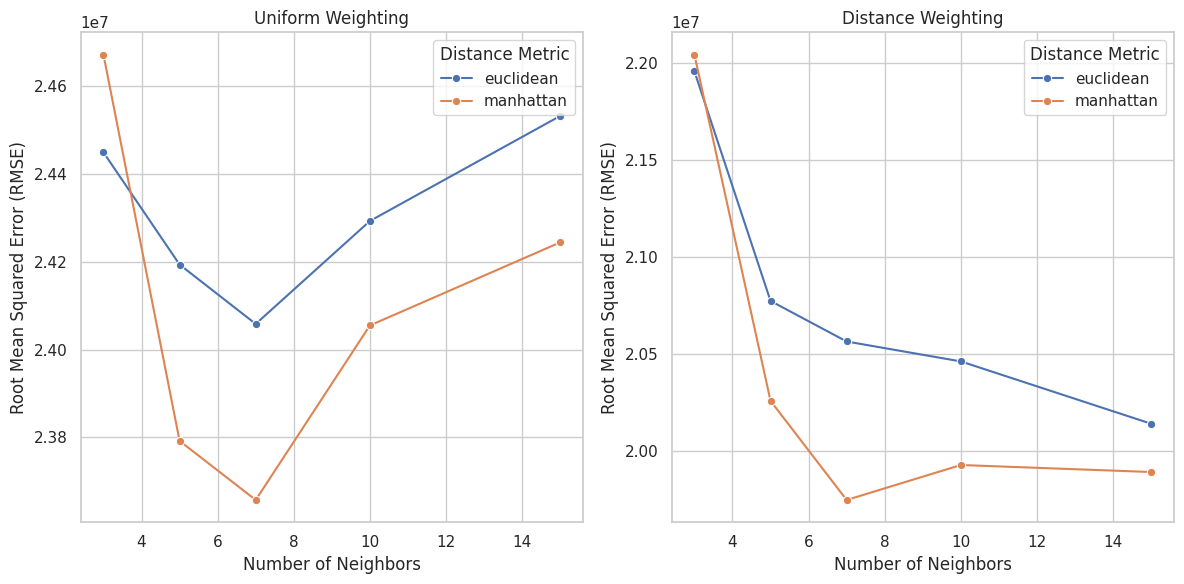

In [ ]:
# KNN model - calculating feature importances
# Calculate RMSE from negative MSE
df_results = pd.DataFrame(grid_search_knn.cv_results_)
df_results['rmse'] = np.sqrt(-df_results['mean_test_score'])

# Plotting
plt.figure(figsize=(12, 6))

# Plot for uniform weighting
plt.subplot(1, 2, 1)
sns.lineplot(x='param_n_neighbors', y='rmse', hue='param_metric', marker='o',
             data=df_results[df_results['param_weights'] == 'uniform'])
plt.title('Uniform Weighting')
plt.xlabel('Number of Neighbors')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend(title='Distance Metric')

# Plot for distance weighting
plt.subplot(1, 2, 2)
sns.lineplot(x='param_n_neighbors', y='rmse', hue='param_metric', marker='o',
             data=df_results[df_results['param_weights'] == 'distance'])
plt.title('Distance Weighting')
plt.xlabel('Number of Neighbors')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend(title='Distance Metric')

plt.tight_layout()
plt.show()

In [ ]:
# KNN model - calculating feature importances

# Initialize KNN with the best parameters
knn = KNeighborsRegressor(**grid_search_knn.best_params_)

# Fit the model
knn.fit(X_train_scaled, y_train)

# Calculate the baseline mean squared error
baseline_mse = mean_squared_error(y_test, y_pred_knn)

# Calculate feature importances
feature_importances = []
for i in range(X_train_scaled.shape[1]):
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])
    y_pred_permuted = knn.predict(X_test_permuted)
    permuted_mse = mean_squared_error(y_test, y_pred_permuted)
    feature_importance = abs(baseline_mse - permuted_mse)
    feature_importances.append(feature_importance)

# Normalize feature importances
feature_importances = np.array(feature_importances)
feature_importances /= np.max(feature_importances)

# Print feature importances
print("Feature Importances:")
for feature_name, importance in zip(X.columns, feature_importances):
    print(f"{feature_name}: {importance:.4f}")

Feature Importances:
achievement_count: 1.0000
Contribution: 0.0756
xG: 0.3442
Age: 0.4700
MP: 0.0277
Min: 0.2393
90s: 0.5589
Starts: 0.4704
Subs: 0.1270
unSub: 0.4036
xG: 0.4909
npxG: 0.3678
xAG: 0.1162
xG+xAG: 0.2799
xA: 0.7682
npxG+xAG: 0.2175
G-xG: 0.7267
np:G-xG: 0.3408
A-xAG: 0.3417
npxG/Sh: 0.3239
Sh: 0.3167
G/Sh: 0.4376
G/SoT: 0.1791
SoT: 0.4087
SoT%: 0.3556
Dist: 0.0121
FK: 0.2308
Gls: 0.4396
Ast: 0.1198
G+A: 0.4784
G-PK: 0.4710
PK: 0.5078
PKatt: 0.4652
PKm: 0.2135


In [ ]:
# decision tree regressor - optimized parameters
from sklearn.tree import DecisionTreeRegressor

# X and y are already defined

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for the Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the Decision Tree Regressor
dtree = DecisionTreeRegressor(random_state=42)

# Set up GridSearchCV with a modest number of combinations
grid_search_dtree = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=3,
                                 scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit grid search to the training data
grid_search_dtree.fit(X_train, y_train)

# Get the best estimator
best_dtree = grid_search_dtree.best_estimator_

# Make predictions with the best model
y_pred_dtree = best_dtree.predict(X_test)

# Calculate RMSE and R^2
rmse_dtree = np.sqrt(mean_squared_error(y_test, y_pred_dtree))
r2_dtree = r2_score(y_test, y_pred_dtree)

# Print the performance metrics rounded to two decimal places
print("Optimized Decision Tree Regressor")
print(f"RMSE: {round(rmse_dtree, 2)}")
print(f"R^2: {round(r2_dtree, 2)}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Optimized Decision Tree Regressor
RMSE: 18434313.06
R^2: 0.6


In [ ]:
### decided to not cut the data
# finding the best cut of data in order to eliminate any major outliers that might imapct predictions
# using random forest regressor since the model had the best evaluation statistics
'''
# Define percentile thresholds to test
percentile_thresholds = [(0.01, 0.99), (0.05, 0.95), (0.10, 0.90), (0.15, 0.85)]

results = []

for lower, upper in percentile_thresholds:
    # Filter the dataset to remove outliers based on the current percentile thresholds
    lower_bound = y.quantile(lower)
    upper_bound = y.quantile(upper)
    indices = y[(y > lower_bound) & (y < upper_bound)].index
    X_filtered = X.loc[indices]
    y_filtered = y.loc[indices]

    # Sample a subset of the data for quicker hyperparameter tuning
    X_sample, _, y_sample, _ = train_test_split(X_filtered, y_filtered, test_size=0.9, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_sample_scaled = scaler.fit_transform(X_sample)

    # Define the parameter grid for Random Forest
    param_grid = {
        'n_estimators': [100, 200],  # Reduced number of trees options
        'max_features': ['auto'],    # Most common option for classification
        'max_depth': [10, 20]        # Simplified depth options
    }

    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(random_state=42)

    # Set up the RandomizedSearchCV
    random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                          n_iter=10,  # Number of parameter settings sampled
                                          cv=3,       # Reduced number of folds
                                          scoring='neg_mean_squared_error',
                                          n_jobs=-1,
                                          random_state=42,
                                          verbose=2)

    # Fit random search to the scaled subset of data
    random_search_rf.fit(X_sample_scaled, y_sample)

    # Get the best estimator
    best_rf = random_search_rf.best_estimator_

    # Prepare the full dataset for prediction
    X_filtered_scaled = scaler.transform(X_filtered)
    X_train, X_test, y_train, y_test = train_test_split(X_filtered_scaled, y_filtered, test_size=0.2, random_state=42)

    # Fit the best Random Forest model
    best_rf.fit(X_train, y_train)

    # Make predictions with the best model
    y_pred_rf = best_rf.predict(X_test)

    # Calculate RMSE and R^2
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2_rf = r2_score(y_test, y_pred_rf)

    # Store results
    results.append({
        'lower_percentile': lower,
        'upper_percentile': upper,
        'RMSE': round(rmse_rf, 2),
        'R^2': round(r2_rf, 2)
    })

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)
'''

"\n# Define percentile thresholds to test\npercentile_thresholds = [(0.01, 0.99), (0.05, 0.95), (0.10, 0.90), (0.15, 0.85)]\n\nresults = []\n\nfor lower, upper in percentile_thresholds:\n    # Filter the dataset to remove outliers based on the current percentile thresholds\n    lower_bound = y.quantile(lower)\n    upper_bound = y.quantile(upper)\n    indices = y[(y > lower_bound) & (y < upper_bound)].index\n    X_filtered = X.loc[indices]\n    y_filtered = y.loc[indices]\n\n    # Sample a subset of the data for quicker hyperparameter tuning\n    X_sample, _, y_sample, _ = train_test_split(X_filtered, y_filtered, test_size=0.9, random_state=42)\n\n    # Standardize the features\n    scaler = StandardScaler()\n    X_sample_scaled = scaler.fit_transform(X_sample)\n\n    # Define the parameter grid for Random Forest\n    param_grid = {\n        'n_estimators': [100, 200],  # Reduced number of trees options\n        'max_features': ['auto'],    # Most common option for classification\n     

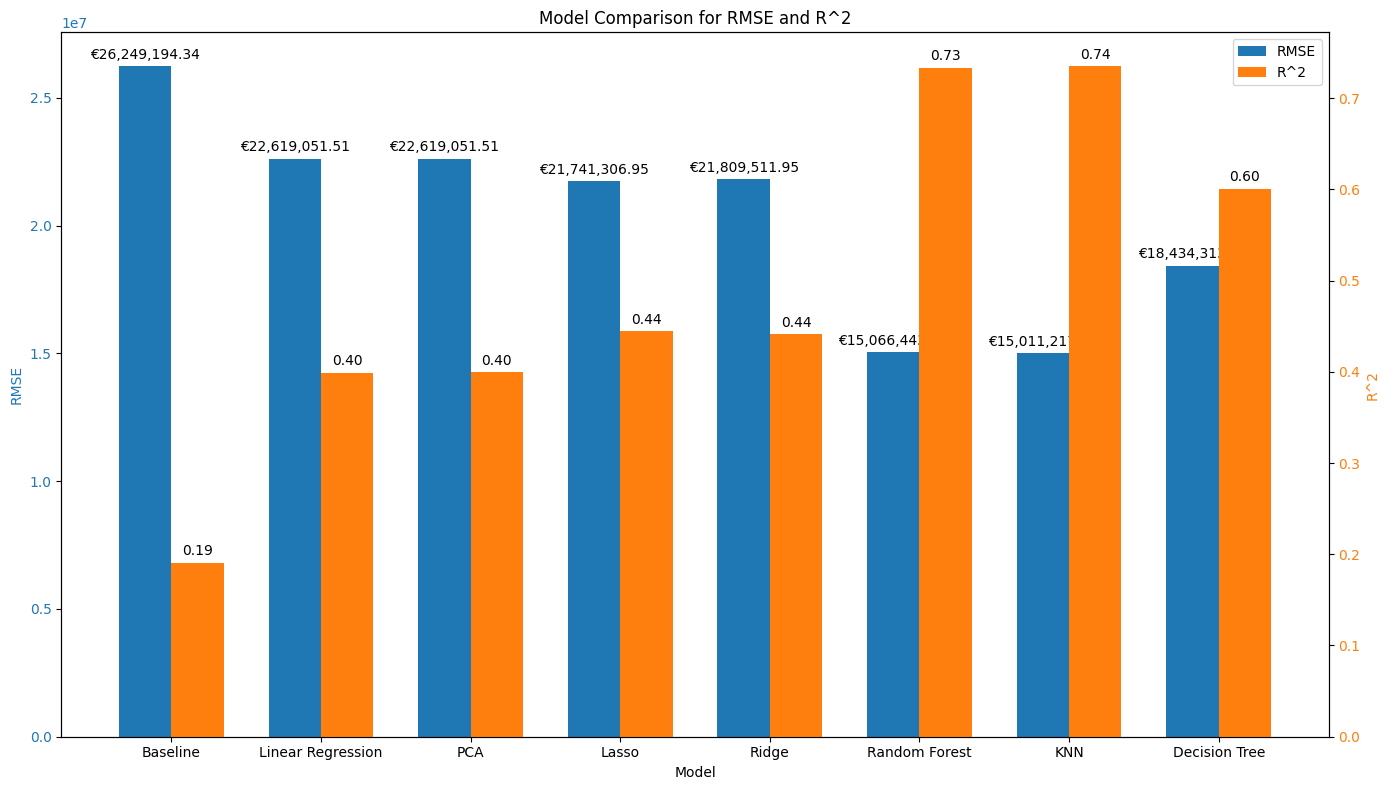

In [ ]:
# plotting all the different models' evaluation statistics
# Model names
models = ['Baseline', 'Linear Regression', 'PCA', 'Lasso', 'Ridge', 'Random Forest', 'KNN', 'Decision Tree']

# R^2 scores for each model
r2_scores = [r2_base, r2, r2_rounded, r2_lasso, r2_ridge, r2_rf_1, r2_knn, r2_dtree]

# RMSE scores for each model
rmse_scores = [rmse_base, rmse, rmse_rounded, rmse_lasso, rmse_ridge, rmse_rf_1, rmse_knn, rmse_dtree]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plotting RMSE scores
rects1 = ax1.bar(x - width/2, rmse_scores, width, label='RMSE', color='tab:blue')

# Creating a twin of the original axes to plot R^2 scores
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, r2_scores, width, label='R^2', color='tab:orange')

# Adding labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color='tab:blue')
ax2.set_ylabel('R^2', color='tab:orange')
ax1.set_title('Model Comparison for RMSE and R^2')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Function to add labels on the bars
def add_labels(rects, ax, is_currency=False):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:,.2f}' if not is_currency else f'€{height:,.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to add labels to the bars
add_labels(rects1, ax1, is_currency=True)  # RMSE values are typically large, treating as currency for thousands separator
add_labels(rects2, ax2)  # R^2 values

# Adding a legend to the graph
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

fig.tight_layout()  # To ensure good spacing

# Show the plot
plt.show()


Analysis of Model kNN and its residuals

In [ ]:
# Create a DataFrame from the actual and predicted values
residuals_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_knn
})

# Calculate residuals as a percentage of the actual values
residuals_df['Residuals as % of Value'] = (residuals_df['Actual'] - residuals_df['Predicted']) / residuals_df['Actual'] * 100


residuals_df['Abs_Residuals as % of Value'] = residuals_df['Residuals as % of Value'].abs()


high_residuals_df = residuals_df.sort_values(by='Abs_Residuals as % of Value', ascending=False)


high_residuals_df_non_zero=high_residuals_df[high_residuals_df['Abs_Residuals as % of Value']>0]
high_residuals_df_non_zero.head(10)

,Actual,Predicted,Residuals as % of Value,Abs_Residuals as % of Value
312,4000000,3.090086e+07,-672.521588,672.521588
482,3500000,2.332644e+07,-566.469771,566.469771
390,500000,3.000000e+06,-500.000000,500.000000
678,9000000,4.649898e+07,-416.655371,416.655371
782,7500000,3.874910e+07,-416.654674,416.654674
732,3500000,1.730124e+07,-394.321215,394.321215
475,3000000,1.458290e+07,-386.096817,386.096817
668,3000000,1.396584e+07,-365.527948,365.527948
478,10000000,4.291261e+07,-329.126097,329.126097
800,1500000,6.408792e+06,-327.252799,327.252799


In [ ]:
high_residuals_df_non_zero_features = playerstats_df_2.loc[high_residuals_df_non_zero.index]

print("Features of High Residual Cases:")
high_residuals_df_non_zero_features.head(10)

Features of High Residual Cases:


,Player,xG,Season,Age,Team,Comp,MP,Min,90s,Starts,...,player_club_id,market_value_in_eur,date,club_id,name,season,own_goals,Contribution,detail_season_id,achievement_count
312,Pierre-Emerick Aubameyang,15.4,2023-2024,34,Marseille,fr Ligue 1,28,2114.0,23.5,24,...,244,4000000,2023-06-20,244,Olympique,2023,47,0.404255,NaN,0.0
482,Olivier Giroud,12.7,2022-2023,35,Milan,it Serie A,33,2139.0,23.8,25,...,5,3500000,2022-06-07,5,Associazione,2022,79,0.227848,2022.0,10.0
390,Patrick Cutrone,7.8,2017-2018,19,Milan,it Serie A,28,1503.0,16.7,17,...,5,500000,2017-06-08,5,Associazione,2017,90,0.122222,2017.0,3.0
678,Mark Uth,7.4,2019-2020,27,2 Teams,de Bundesliga,23,1515.0,16.8,18,...,33,9000000,2019-10-02,33,FC,2019,49,0.204082,NaN,0.0
782,Matteo Politano,9.4,2017-2018,23,Sassuolo,it Serie A,36,2812.0,31.2,33,...,6574,7500000,2017-06-08,6574,Unione,2017,34,0.411765,NaN,0.0
732,Sergio León,11.0,2017-2018,28,Betis,es La Liga,31,1978.0,22.0,23,...,150,3500000,2017-06-05,150,Real,2017,65,0.184615,NaN,0.0
475,Martin Harnik,8.6,2017-2018,30,Hannover 96,de Bundesliga,30,1888.0,21.0,21,...,42,3000000,2017-06-27,42,Hannover,2017,50,0.220000,NaN,0.0
668,Kalifa Coulibaly,9.5,2018-2019,26,Nantes,fr Ligue 1,32,1751.0,19.5,19,...,995,3000000,2018-06-04,995,Football,2018,48,0.208333,2018.0,3.0
478,Ludovic Ajorque,10.6,2021-2022,27,Strasbourg,fr Ligue 1,36,2738.0,30.4,31,...,667,10000000,2021-04-09,667,Racing,2021,60,0.333333,NaN,0.0
800,Cristhian Stuani,9.7,2022-2023,35,Girona,es La Liga,32,1090.0,12.1,8,...,12321,1500000,2022-06-29,12321,Girona,2022,59,0.152542,NaN,0.0


Index(['Actual', 'Predicted', 'Residuals as % of Value',
       'Abs_Residuals as % of Value', 'Comp'],
      dtype='object')
      Actual     Predicted  Residuals as % of Value  \
312  4000000  3.090086e+07              -672.521588   
482  3500000  2.332644e+07              -566.469771   
390   500000  3.000000e+06              -500.000000   
678  9000000  4.649898e+07              -416.655371   
782  7500000  3.874910e+07              -416.654674   

     Abs_Residuals as % of Value           Comp  
312                   672.521588     fr Ligue 1  
482                   566.469771     it Serie A  
390                   500.000000     it Serie A  
678                   416.655371  de Bundesliga  
782                   416.654674     it Serie A  


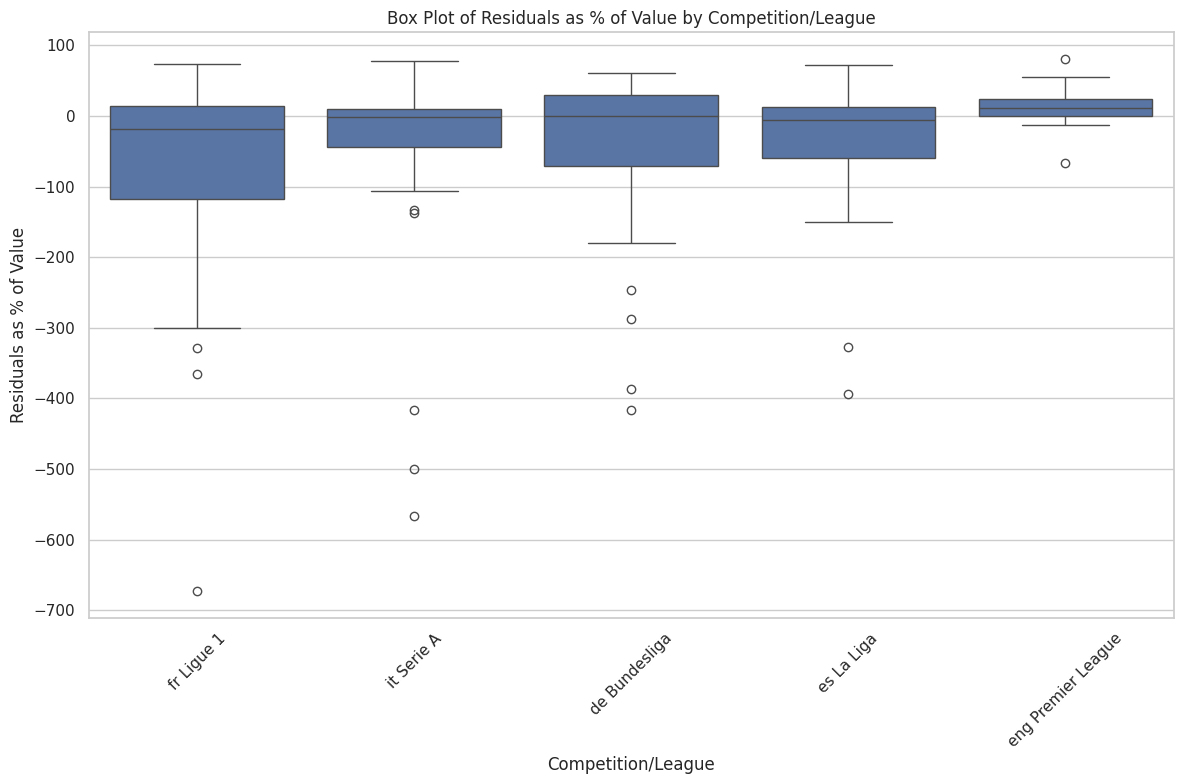

In [ ]:
##Boxplot of Residuals by League

resi_df = high_residuals_df_non_zero.merge(high_residuals_df_non_zero_features[['Comp']],
                                             left_index=True, right_index=True)
resi_df_ = resi_df[resi_df['Comp'] != '2 Comps']


print(resi_df_.columns)
print(resi_df_.head())


sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))


sns.boxplot(x='Comp', y='Residuals as % of Value', data=resi_df_)


plt.title('Box Plot of Residuals as % of Value by Competition/League')
plt.xlabel('Competition/League')
plt.ylabel('Residuals as % of Value')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# target variable using most recent valuations
# train data on using players from sportsref (per season data)
# apply model to test set

# using functions to create binary variables for acheivement
# everything per season no averages

# lasso regression
# ridge regression
# simple regression
  ## PCA
# random forest regressor
  ## optimizing using cross val
# kNN regressor
# decision tree regressor
# neural nets